In [1]:
#extract main expriment data from blur epi data

import os
import numpy as np
import subprocess

def listdir(path,hemi):
    num = []
    for file in os.listdir(path):
        temp = file.split(".")
        if temp[0] == "newNodes_"+hemi+"_SurfCoord":
            num.append(temp[1])
    return num

hemiList = ["lh","rh"]
subjname = "bg_data"
subSurName = "bg"
run = range(1,10)

for hemi in hemiList:
    boldDataFilePath = "/mnt/data_disk/fmridata/all_subj/surfaceProj/afni/mainExp/"+subSurName+"/"+subSurName+".surf.results/"
    filePath = "/home/hh/study/python/code/ml/nipype_tutorial/bingfreesurfer/"+subjname+"/SUMA"
    num = listdir(filePath,hemi)
    for r in run:
        for i in range(len(num)):
            command1 = "cd "+filePath+";\
            ConvertDset -input "+boldDataFilePath+"pb04."+subSurName+".surf."+hemi+".r0"+str(r)+".blur.niml.dset \
            -node_select_1D newNodes_"+hemi+"_SurfCoord."+num[i]+".1D \
            -o_1D_stdout > mainExp_"+hemi+"_roi"+num[i]+"_run"+str(r)+".Nodesvals.txt"

            subprocess.call(command1, shell=True)

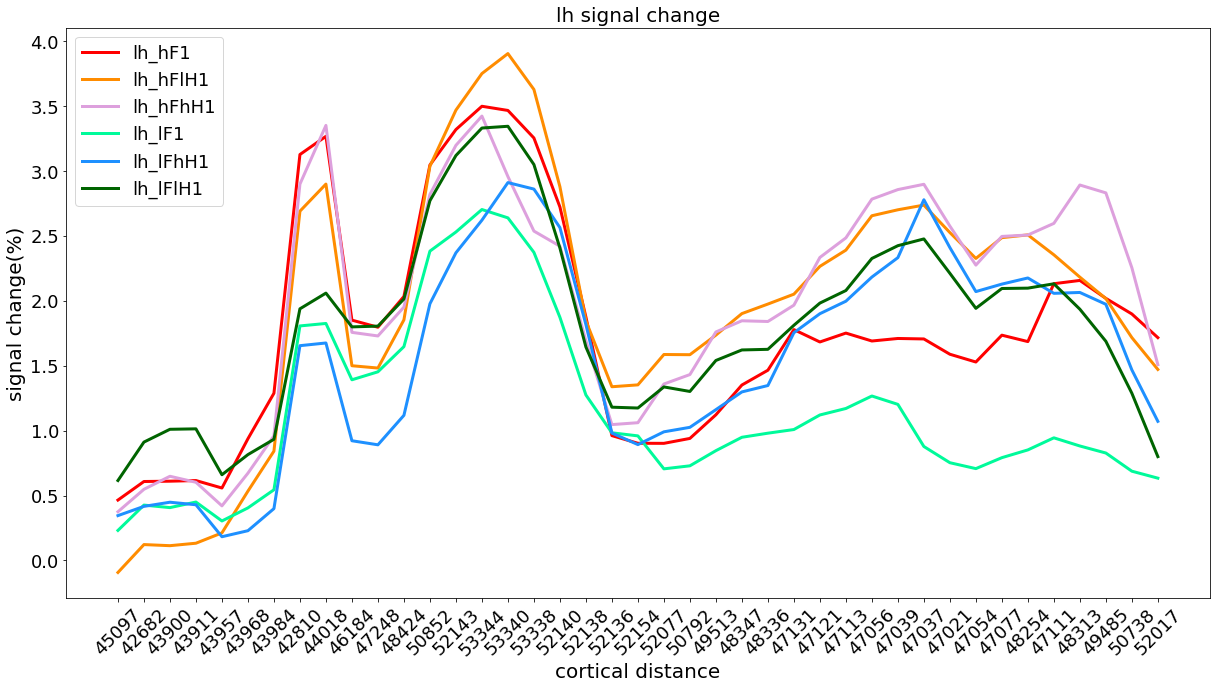

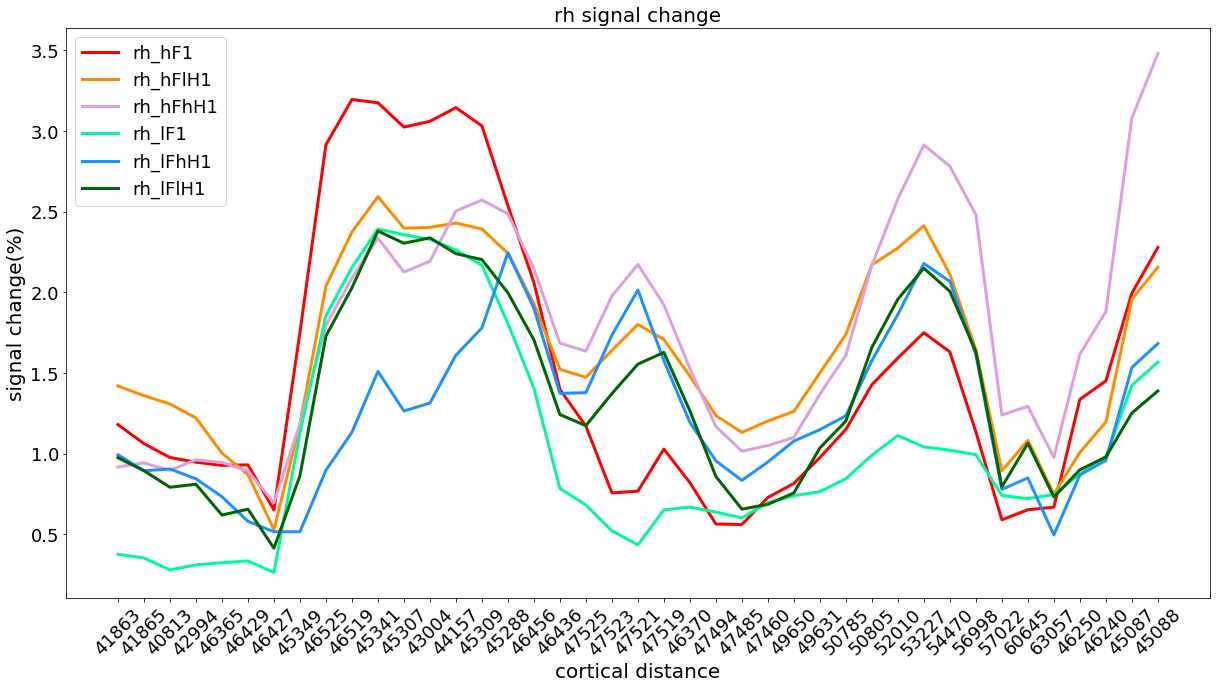

In [67]:
#画出主实验的percent single change

#数据整理，然后求信号变化比
#画出percent single change

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn.apionly as sns
#读取所有run的bold信号的大小
#把所有node的值相加，求平均,即求这个roi的平均的时间序列
def getBoldData(boldInfileDir,roiName):
    temp = []
    x =[]
    boldFileName = roiName
    boldFinalDir = os.path.join(boldInfileDir,boldFileName)
    with open(boldFinalDir) as f:
        for line ,i in enumerate(f.readlines()):
            if i[0] != "#":
                temp.append(np.array(map(float,i.split(" ")[1:])))
    aveRoiData = np.zeros((1,len(temp[0])))
    for i in range(0,len(temp)-1):
#         print "temp",temp[i],boldFinalDir         
        temp[i].shape = 1,136
        aveRoiData = aveRoiData+temp[i]
    aveRoiData = aveRoiData/(len(temp)-1)
    aveRoiData = aveRoiData[0]
    return aveRoiData

def listdir(filePath,nodeIndices,hemi):
    path = os.path.join(filePath,nodeIndices)
    num = []
    with open(path) as f:
        for line ,i in enumerate(f.readlines()):
            num.append(int(float(i[3:])))
    return num

def getformat(filePath,hemi):
    #contract labels
    index = []
    for h in range(len(hemi)):
        #get roiName
        nodeIndices = "nodelocations_"+hemi[h]+".1D"
        roiName = listdir(filePath,nodeIndices,hemi[h])
        for i in range(len(roiName)):
            for j in range(1,137):
                index.append((hemi[h],'roi'+str(roiName[i]), str(j)))


    mul_index = pd.MultiIndex.from_tuples(index)
    pop = pd.Series(index=mul_index)
    pop_df = pd.DataFrame({'run1':pop,'run2':pop})
    return pop_df
    
def getArrangedData(filePath,hemi,run):
    pop_df = getformat(filePath,hemi)
    #extract data and form the final fomat
    for h in range(len(hemi)):
        #get roiName
        nodeIndices = "nodelocations_"+hemi[h]+".1D"
        roiName = listdir(filePath,nodeIndices,hemi[h])
        for i in range(len(roiName)):
            for r in run:
                nodesName = "mainExp_"+hemi[h] +"_roi"+str(roiName[i])+"_run"+str(r)+".Nodesvals.txt"
                pop_df.loc[(hemi[h],"roi"+str(roiName[i])),"run"+str(r)] = getBoldData(filePath,nodesName)
    return pop_df



def getStimulusTimeFileFormat(path,run):
    stimuliName = []
    index = []
    for file in os.listdir(path):
        temp = file.split(".")
        stimuliName.append(temp[0])
        
    for sti in stimuliName:
        for r in run:
            index.append((sti,"run"+str(r)))
            
    mul_index = pd.MultiIndex.from_tuples(index)
    pop = pd.Series(index=mul_index)
    pop_df = pd.DataFrame({'value':pop})
    return pop_df    

def getAllStimulusFileName(path):
    stimuliName = []
    allStimulusTimeFile = getStimulusTimeFileFormat(path,run)
    
    for file in os.listdir(path):
        temp = file.split(".")
        stimuliName.append(temp[0])
        
    for sti in stimuliName:
        stimulusFilePath = os.path.join(path,sti+".txt")
        with open(stimulusFilePath) as f:
            for line ,i in enumerate(f.readlines()):
                if line<9:
                    allStimulusTimeFile.loc[sti,"run"+str(line+1)] = int(i.strip())
    return allStimulusTimeFile

                    
def getAllRunPsc(allStimulusTimeFile,pscAllData,hemi,run):
    trNumber = 12
    countBlockNum = 5
    stimuluName = " "
    for h in range(len(hemi)):
        nodeIndices = "nodelocations_"+hemi[h]+".1D"
        roiName = listdir(filePath,nodeIndices,hemi[h])
        for stimuliType in allStimulusTimeFile.index.levels[0]:
            for i in range(len(roiName)):
                allRunPsc = np.zeros([trNumber,1],int)
                allRunRawData = []
                for r in run:
                    tem = allStimulusTimeFile.loc[(stimuliType,"run"+str(r))]
                    perRunPsc = np.zeros([trNumber,1],int)
                    singleData = pscAllData.loc[(hemi[h],"roi"+str(roiName[i])),"run"+str(r)]
                    for j in tem:
                        j = int(j/2)
                        baseline = singleData[j-3:j-1]
                        stimuliTime = singleData[j-1:j+trNumber]
                        baseline = np.sum(baseline)/2
                        psc = (stimuliTime - baseline)/baseline*100
                        pscAllData.loc[(hemi[h],"roi"+str(roiName[i])),"run"+str(r)][j-1:j+trNumber] = psc
    return pscAllData

def drawAllRunPsc(allStimulusTimeFile,pscAllData,hemi,run):
    trNumber = 12
    for h in range(len(hemi)):
        nodeIndices = "nodelocations_"+hemi[h]+".1D"
        roiName = listdir(filePath,nodeIndices,hemi[h])
        
        for i in range(len(roiName)):
            
            fig, ax = plt.subplots()
            fig.set_size_inches(10.5, 5.5)
            plt.title(hemi[h]+" signal change")
            plt.xlabel("time (tr)")
            plt.ylabel("signal change(%)")

#         for stimuliType in allStimulusTimeFile.index.levels[0]:
            stype = ["hF1","lF1","hH1","lH1"]
            for stimuliType in stype:
                allRunRawData = []
                for r in run:
                    tem = allStimulusTimeFile.loc[(stimuliType,"run"+str(r))]
                    singleData = pscAllData.loc[(hemi[h],"roi"+str(roiName[i])),"run"+str(r)]
                    for j in tem:
                        j = int(j/2)
                        psc = singleData[j-1:j+trNumber]
                        allRunRawData.append(psc)
                        
                allRunRawData = np.mat(allRunRawData).reshape(len(tem)*len(run),trNumber+1)

                X_std = np.std(allRunRawData, axis=0) # axis=0，计算每一列的均值
                X_mean = np.mean(allRunRawData, axis=0) # axis=0，计算每一列的均值
                X_mean = X_mean.tolist()[0]
                X_std = X_std.tolist()[0]
                x = list(range(len(X_mean)))
                plt.plot(x, X_mean, label=str(roiName[i])+stimuliType)
#                 plt.errorbar(x, X_mean, yerr=X_std,label=str(roiName[i])+stimuliType)
                plt.legend()
            plt.show()
    return X_mean 

def getAllRoiAverageData(allStimulusTimeFile,pscAllData,hemi,run):
    trNumber = 12
    countBlockNum = 5
    stimuluName = " "
    for h in range(len(hemi)):
        nodeIndices = "nodelocations_"+hemi[h]+".1D"
        roiName = listdir(filePath,nodeIndices,hemi[h])
        
        fig, ax = plt.subplots()
        fig.set_size_inches(20.5, 10.5)
        
#         color = ["darkorchid", "dodgerblue" ,"royalblue" ,"darkolivegreen" ,"hotpink" ,  "darkorange", "maroon"]
        color = ["midnightblue","darkorchid","darkgreen","dodgerblue","mediumspringgreen","plum", "darkorange","red"]
        #设置图例并且设置图例的字体及大小
        font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18,
        }
        
        #设置坐标刻度值的大小以及刻度值的字体
        plt.tick_params(labelsize=18)
        labels = ax.get_xticklabels() + ax.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]

        #设置横纵坐标的名称以及对应字体格式
        font2 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20,
        }
        plt.xlabel("cortical distance",font2)
        plt.ylabel("signal change(%)",font2)
        plt.title(hemi[h]+" signal change",font2)
   

        stype = ["hF1","hFlH1","hFhH1","lF1","lFhH1","lFlH1"]
#         stype = ["hF1","lF1","hH1","lH1"]
        for stimuliType in stype:
#         for stimuliType in allStimulusTimeFile.index.levels[0]:
            allRoiMaxPsc = []
            for i in range(len(roiName)):
                allRunMaxPsc = []
                allRunRawData = []
                for r in run:
                    tem = allStimulusTimeFile.loc[(stimuliType,"run"+str(r))]
                    singleData = pscAllData.loc[(hemi[h],"roi"+str(roiName[i])),"run"+str(r)]
                    for j in tem:
                        j = int(j/2)
                        psc = singleData[j-1:j+trNumber]
                        allRunRawData.append(psc)
                        
                allRunRawData = np.mat(allRunRawData).reshape(len(tem)*len(run),trNumber+1) 
#                 allRunMaxPsc = np.mean(np.max(allRunRawData, axis=1))#选出每个run中最大的值，把这些最大值相加，求平均
                allRunMaxPsc = np.max(np.mean(allRunRawData, axis=0))#把每个run的每个tr的值相加，求平均，然后在求出最大值
                allRoiMaxPsc.append(allRunMaxPsc)
                
        
            x = list(range(1,len(allRoiMaxPsc)+1,1))
            plt.xticks(x, roiName, rotation=45 )
            plt.plot(x, allRoiMaxPsc, label=hemi[h]+"_"+stimuliType,color=color.pop(),linewidth=3.0,ms=8,markerfacecolor='none')
            legend = plt.legend(prop=font1,loc='upper left')

    plt.show()
    return allRoiMaxPsc


hemi = ["lh","rh"]
subjname = ["bg_data"]
subSurName = 'bg'
run = range(1,10)
boldDataFilePath = "/mnt/data_disk/fmridata/all_subj/surfaceProj/afni/mainExp/"+subSurName+"/"+subSurName+".surf.results/stimuli"

for s in range(len(subjname)):
    filePath = "/home/hh/study/python/code/ml/nipype_tutorial/bingfreesurfer/"+subjname[s]+"/SUMA"
    alll_data = getArrangedData(filePath,hemi,run)
    allStimulusTimeFile = getAllStimulusFileName(boldDataFilePath)
    pscAllData = getAllRunPsc(allStimulusTimeFile,alll_data,hemi,run)           
    getAllRoiAverageData(allStimulusTimeFile,pscAllData,hemi,run)
#     X_mean = drawAllRunPsc(allStimulusTimeFile,pscAllData,hemi,run)


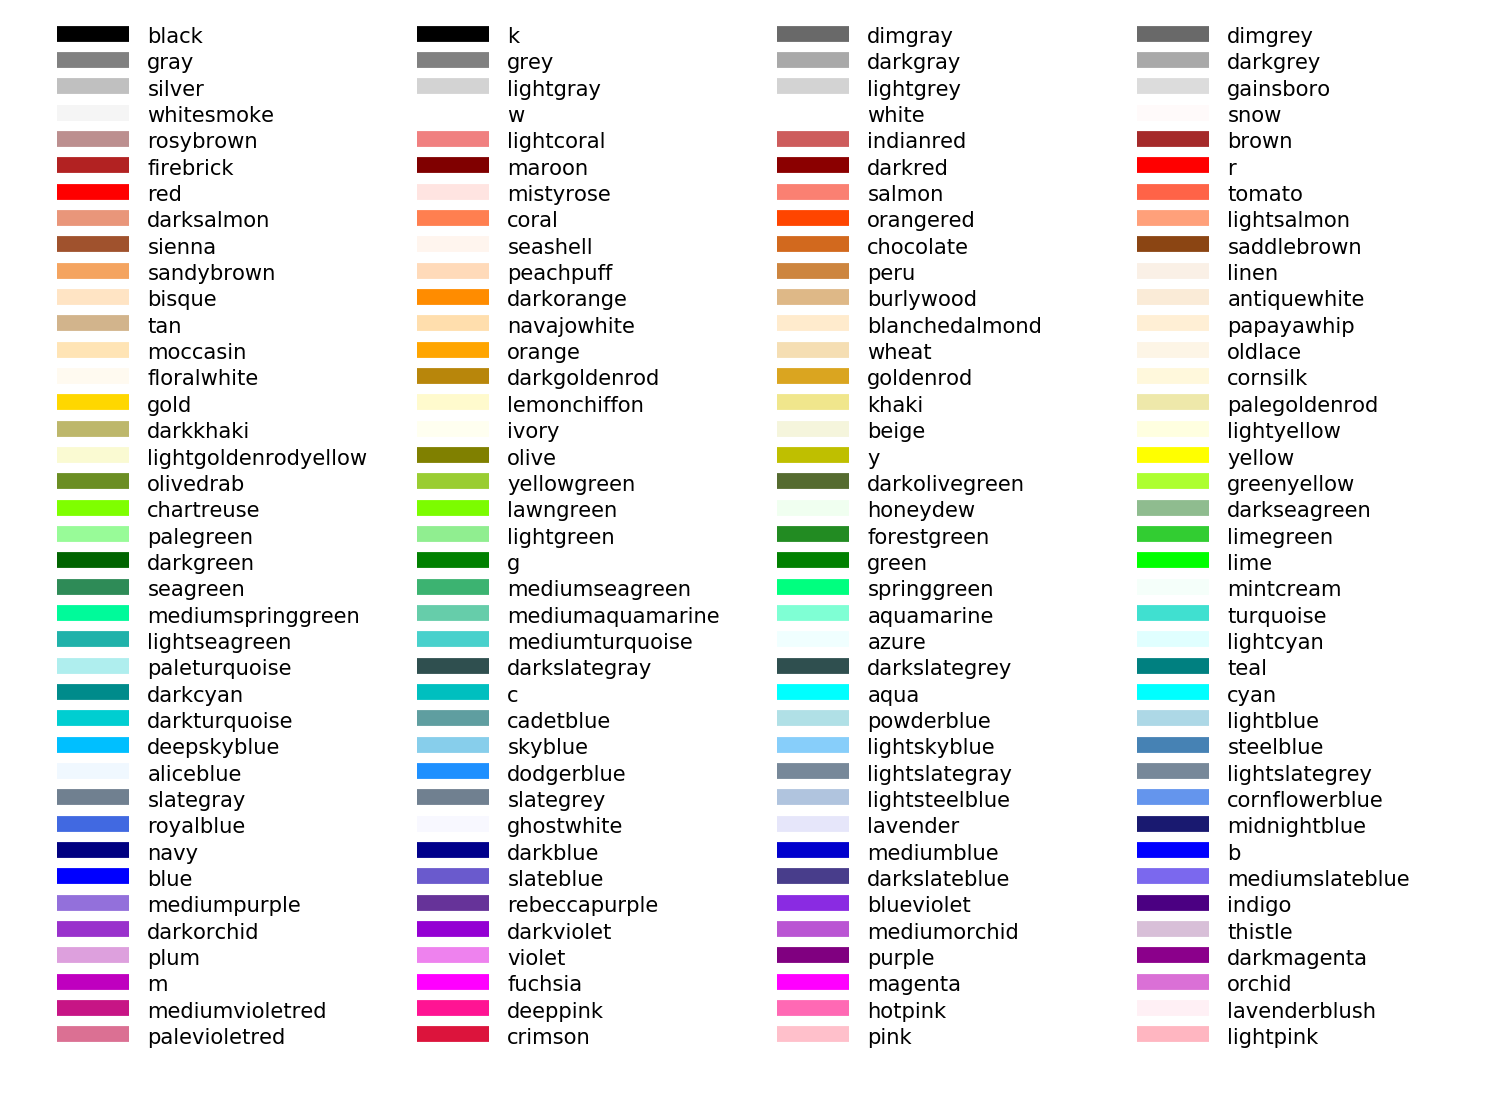

In [54]:

from __future__ import division

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

n = len(sorted_names)
ncols = 4
nrows = n // ncols + 1

fig, ax = plt.subplots(figsize=(20, 15))

# Get height and width
X, Y = fig.get_dpi() * fig.get_size_inches()
h = Y / (nrows + 1)
w = X / ncols

for i, name in enumerate(sorted_names):
    col = i % ncols
    row = i // ncols
    y = Y - (row * h) - h

    xi_line = w * (col + 0.05)
    xf_line = w * (col + 0.25)
    xi_text = w * (col + 0.3)

    ax.text(xi_text, y, name, fontsize=(h * 0.8),
            horizontalalignment='left',
            verticalalignment='center')

    ax.hlines(y + h * 0.1, xi_line, xf_line,
              color=colors[name], linewidth=(h * 0.6))

ax.set_xlim(0, X)
ax.set_ylim(0, Y)
ax.set_axis_off()

fig.subplots_adjust(left=0, right=1,
                    top=1, bottom=0,
                    hspace=0, wspace=0)
plt.show()